In [11]:
from bitcoin_listener import OrderBook
import bitcoin_listener as btcl

In [12]:
o = OrderBook(exchange='bitstamp')

In [13]:
o.fetch_one()

In [8]:
#o.flush_orderbook()

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
# from list of dates read file
# read ask-bid-vol
# read ask-bid-orderbook til n/vol/...
# read ask-bid and estimate params
# save summary on database

In [ ]:
#technical analysis

In [106]:
from bitcoin_listener import OrderBook
import os
import gzip
import bitcoin_listener as btcl
source_orderbook = btcl.config['DEFAULT']['source_orderbook']
#source_orderbook = '/home/eol/Documents/bitcoin_compress/orderbook/'


def read_dates(exchange):
    if exchange not in OrderBook.EXCHANGES.keys():
        return []
    p = os.path.join(source_orderbook, exchange)
    return sorted([
        ".".join(f.split(".")[:-1]) for f in os.listdir(p)
        if os.path.isfile(os.path.join(p, f))
    ])

print(read_dates('bitstamp'))

def read_file(exchange, date):
    if exchange not in OrderBook.EXCHANGES.keys():
        return ""
    if date not in read_dates(exchange):
        return ""
    
    p = os.path.join(source_orderbook, exchange, "{}.gz".format(date))
    
    file_text = ""
    with gzip.open(p,'r') as gf: 
        file_text = gf.read().decode('utf-8')
    return file_text

print(read_file('bitstamp', '2018-05-19')[:100])

['2018-05-18', '2018-05-19', '2018-05-20', '2018-05-21']
1526688176|6968 12362|825179,667e4 8,215e5 12,188e4 259,141e5 2,121e5 120,204e5 420,5e7 170,5e7 34,4


In [286]:
import numpy as np
import datetime as dt
def get_orderbook(exchange, date, lim_orderbook=None):
    if exchange not in OrderBook.EXCHANGES.keys():
        return {}
    if date not in read_dates(exchange):
        return {}
    
    adj_price = OrderBook.EXCHANGES[exchange]['best_shift']['price']
    adj_amount = OrderBook.EXCHANGES[exchange]['best_shift']['amount']
    text = read_file(exchange, date)
    lines = [l for l in text.split('\n') if l]
    s = len(lines)
    orderbook = np.ndarray(s, dtype=np.dtype([
        ('epoch', dt.datetime), 
        ('ask_amount', float), 
        ('bid_amount', float), 
        ('ask_qtd', float), 
        ('bid_qtd', float),
        ('ask_orderbook', object), 
        ('bid_orderbook', object),
    ]))
    list_data = []
    for i in range(s):
        line = lines[i]
        data = line.split('|')
        epoch = dt.datetime.fromtimestamp(int(data[0]))
        qtd_askbid = [float(v) for v in data[1].split(' ')]
        list_asks = data[2].split(' ')[:lim_orderbook]
        list_bids = data[3].split(' ')[:lim_orderbook]
        list_ask_prices = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_asks])
        list_ask_amounts = [float(p.split(',')[1])/10**adj_amount for p in list_asks]
        list_bid_prices = np.cumsum([float(p.split(',')[0])/10**adj_price for p in list_bids])
        list_bid_amounts = [float(p.split(',')[1])/10**adj_amount for p in list_bids]
        list_ask_zip = np.array(list(zip(list_ask_prices, list_ask_amounts)))
        list_bid_zip = np.array(list(zip(list_bid_prices, list_bid_amounts)))
        
        orderbook[i]['epoch'] = epoch
        orderbook[i]['ask_amount'] = list_ask_prices[0]
        orderbook[i]['ask_qtd'] = qtd_askbid[0]
        orderbook[i]['ask_orderbook'] = list_ask_zip
        orderbook[i]['bid_amount'] = list_ask_prices[0]
        orderbook[i]['bid_qtd'] = qtd_askbid[1]
        orderbook[i]['bid_orderbook'] = list_bid_zip
    return orderbook

x = get_orderbook('bitstamp', '2018-05-21', 600)

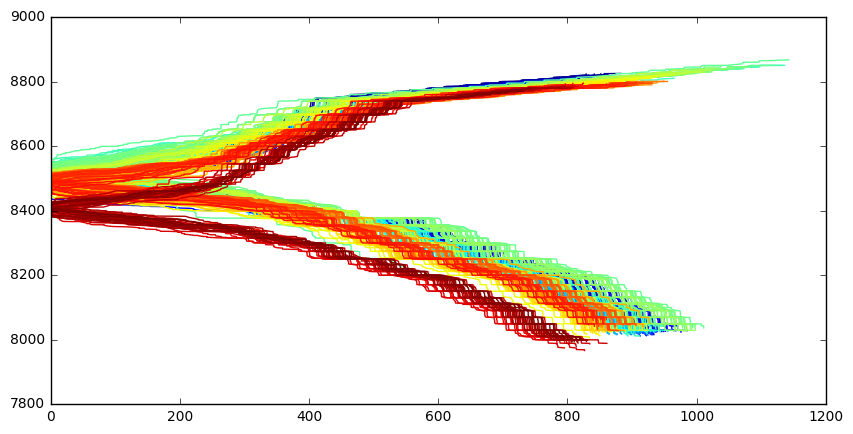

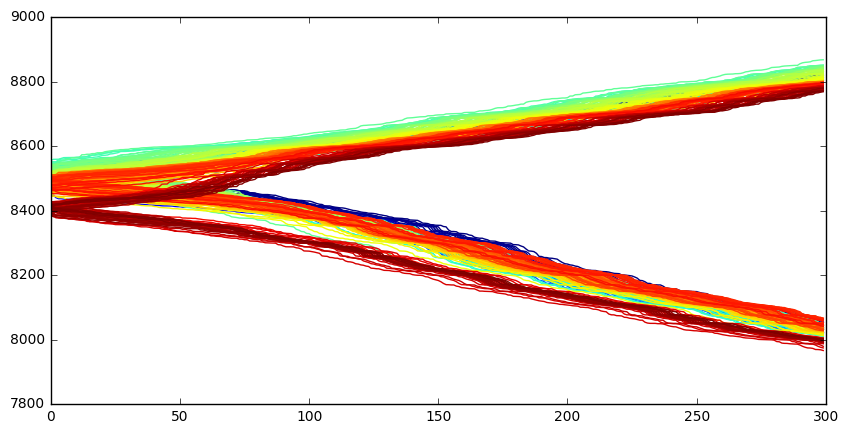

In [297]:
N=0
X=x.size
T = 300

hsv = plt.get_cmap('jet')
colors = hsv(np.linspace(0, 1.0, X))

plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(np.cumsum(x[i+N]['ask_orderbook'][:T,1]), x[i+N]['ask_orderbook'][:T,0], color=colors[i])
    plt.plot(np.cumsum(x[i+N]['bid_orderbook'][:T,1]), x[i+N]['bid_orderbook'][:T,0], color=colors[i])
plt.show()
plt.figure(figsize=(10,5))
for i in range(X-N):
    plt.plot(x[i+N]['ask_orderbook'][:T,0], color=colors[i])
    plt.plot(x[i+N]['bid_orderbook'][:T,0], color=colors[i])
plt.show()

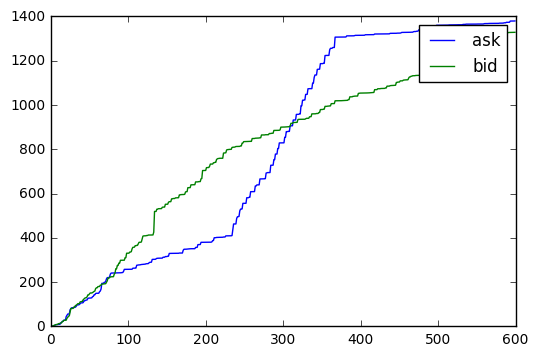

In [303]:
plt.plot(np.cumsum(x[N]['ask_orderbook'][:600,1]), label='ask')
plt.plot(np.cumsum(x[N]['bid_orderbook'][:600,1]), label='bid')
plt.legend()